# Clasificación de imágenes de Radar de Apertura Sintética aplicando CORINE Land Cover adaptada para Colombia mediante Redes Neuronales Convolucionales.
## Versión Final: Datos Escalados, IA Lab RITA.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [58]:
# -*- coding: utf-8 -*-

# Librerías propias para las redes neuronales por convolución
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras import layers
from keras.models import Model
# model architectures

#so
import os
import pathlib

#libreria para el modelo resnet50 
from keras.applications.resnet50 import ResNet50,preprocess_input, decode_predictions
from keras.preprocessing import image


# Libreria para arreglos multidimensionales
import numpy as np
from numpy import asarray
import json
import pickle
# Librería para graficar 
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle
import itertools
from keras.utils.vis_utils import plot_model

import PIL
import PIL.Image
import os

# Librerías para obtener métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve, auc

In [34]:
# Preparación del entorno para trabajar sobre GPU
K.tensorflow_backend._get_available_gpus()
config = tf.ConfigProto( device_count = {'GPU': 1} )
sess = tf.Session(config=config)
keras.backend.set_session(sess)

## Prepare Data

In [21]:
from zipfile import ZipFile
with ZipFile('images.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

### Read data

In [24]:
%ls ./images/8_bit_jpg/train/

11/  21/  22/  23/  24/  31/  32/  33/  52/


In [25]:
path  = "./images/8_bit_jpg/train/" 

num_classes = 9

In [27]:
# data_dir_v1 = pathlib.Path(path_v1)
data_dir = pathlib.Path('./images/8_bit_jpg/')


# image_count_v1 = len(list(data_dir_v1.glob('*/*.jpg')))
image_count = len(list(data_dir.glob('*/*/*.jpg')))


print(image_count)#borrar los del 21 del 3

5586


In [190]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols , figsize=(15,15))
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title],cmap='gray')
        ax.ravel()[ind].set_title(title, fontsize=20)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

In [166]:
target_names = ['11', '21','22','23','24','31','32','33','52']
'images/8_bit_jpg/test/11/000000272.jpg'
im_paths_ = {i:asarray(PIL.Image.open('images/8_bit_jpg/train/{}/000000352.jpg'.format(i))) for i in target_names}


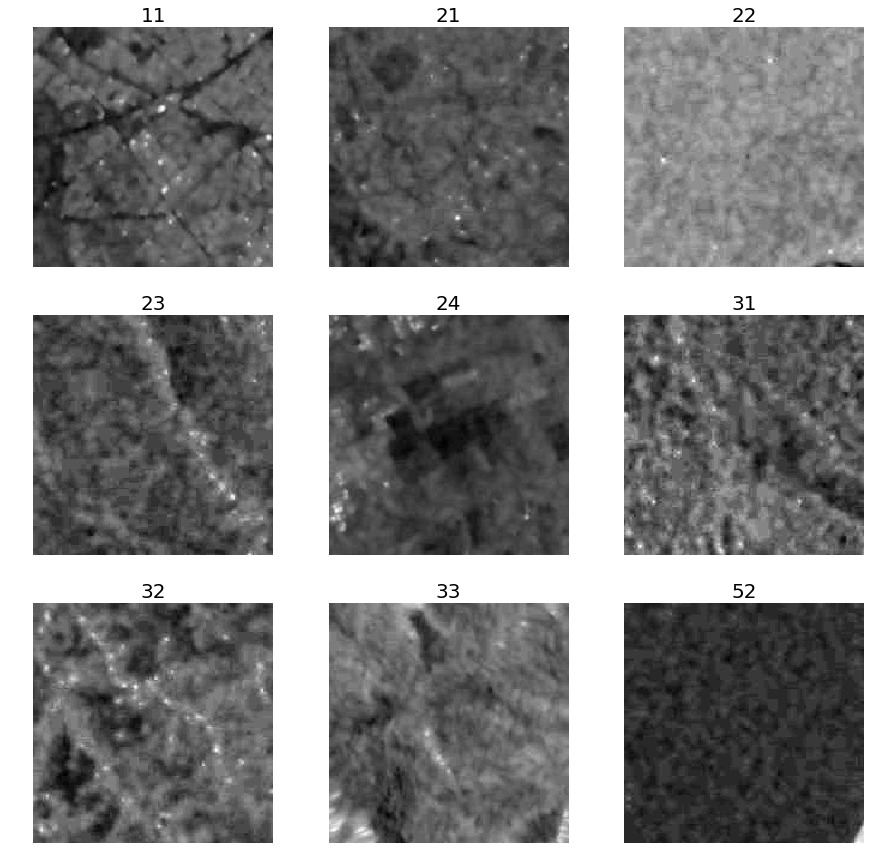

In [277]:
images_0 = {'11':asarray(PIL.Image.open('images/8_bit_jpg/train/11/000000352.jpg'.format(i))),
            '21':asarray(PIL.Image.open('images/8_bit_jpg/train/21/000000352.jpg'.format(i))),
            '22':asarray(PIL.Image.open('images/8_bit_jpg/train/22/000000352.jpg'.format(i))),
            '23':asarray(PIL.Image.open('images/8_bit_jpg/train/23/000000537.jpg'.format(i))),
            '24':asarray(PIL.Image.open('images/8_bit_jpg/train/24/000000352.jpg'.format(i))),
            '31':asarray(PIL.Image.open('images/8_bit_jpg/train/31/000000522.jpg'.format(i))),
            '32':asarray(PIL.Image.open('images/8_bit_jpg/train/32/000000121.jpg'.format(i))),
            '33':asarray(PIL.Image.open('images/8_bit_jpg/train/33/000000186.jpg'.format(i))),
            '52':asarray(PIL.Image.open('images/8_bit_jpg/train/52/000000234.jpg'.format(i))),
           }

figure, ax = plt.subplots(nrows=3,ncols=3 , figsize=(15,15))

ax[0,0].imshow(images_0['11'],cmap='gray')
ax[0,0].set_title('11', fontsize=20)
ax[0,0].set_axis_off()

ax[0,1].imshow(images_0['21'],cmap='gray')
ax[0,1].set_title('21', fontsize=20)
ax[0,1].set_axis_off()

ax[0,2].imshow(images_0['22'],cmap='gray')
ax[0,2].set_title('22', fontsize=20)
ax[0,2].set_axis_off()

ax[1,0].imshow(images_0['23'],cmap='gray')
ax[1,0].set_title('23', fontsize=20)
ax[1,0].set_axis_off()

ax[1,1].imshow(images_0['24'],cmap='gray')
ax[1,1].set_title('24', fontsize=20)
ax[1,1].set_axis_off()

ax[1,2].imshow(images_0['31'],cmap='gray')
ax[1,2].set_title('31', fontsize=20)
ax[1,2].set_axis_off()

ax[2,0].imshow(images_0['32'],cmap='gray')
ax[2,0].set_title('32', fontsize=20)
ax[2,0].set_axis_off()

ax[2,1].imshow(images_0['33'],cmap='gray')
ax[2,1].set_title('33', fontsize=20)
ax[2,1].set_axis_off()

ax[2,2].imshow(images_0['52'],cmap='gray')
ax[2,2].set_title('52', fontsize=20)
ax[2,2].set_axis_off()


[load images keras](https://keras.io/api/preprocessing/image/)

[source](https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator)


In [30]:
#batch size
batch_size = 32
#size of the images
img_height = 200
img_width = 200

## Modelos

### Modelo 1

In [31]:
train_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
        './images/8_bit_jpg/train',  # this is the target directory
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical') 

test_datagen = ImageDataGenerator(rescale=1./255.)

validation_generator = test_datagen.flow_from_directory(
        './images/8_bit_jpg/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        './images/8_bit_jpg/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

step_size_train = train_generator.n/train_generator.batch_size
step_size_validation  = validation_generator.n/validation_generator.batch_size

Found 3349 images belonging to 9 classes.
Found 1113 images belonging to 9 classes.
Found 1124 images belonging to 9 classes.


In [33]:
#Creación Modelo
#Design
# Se define como un modelo secuencial
model = Sequential()

# Se añaden las capas y sus hiperparámetros
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(200, 200, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20
#model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10
#model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5
#model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
# La capa de salida debe tener el mismo número de clases
model.add(Dense(num_classes, activation='softmax'))
#Compilation
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [278]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 32)        102432    
__________

In [104]:
#callbacks
callbacks_m1 = [ModelCheckpoint(filepath="./models/model_1.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_m1 = model.fit_generator(generator = train_generator,
                   steps_per_epoch = step_size_train,
                   validation_data = validation_generator,
                   validation_steps = step_size_validation,
                   epochs=50, callbacks=callbacks_m1)

Epoch 1/50
139/138 [==============================] - 117s 840ms/step - loss: 2.1906 - acc: 0.1393 - val_loss: 2.1871 - val_acc: 0.1470

Epoch 00001: val_loss improved from inf to 2.18712, saving model to ./models/model_1.h5
Epoch 2/50
139/138 [==============================] - 85s 614ms/step - loss: 2.1893 - acc: 0.1301 - val_loss: 2.1891 - val_acc: 0.1325

Epoch 00002: val_loss did not improve from 2.18712
Epoch 3/50
139/138 [==============================] - 83s 601ms/step - loss: 2.1886 - acc: 0.1364 - val_loss: 2.1848 - val_acc: 0.1452

Epoch 00003: val_loss improved from 2.18712 to 2.18476, saving model to ./models/model_1.h5
Epoch 4/50
139/138 [==============================] - 83s 597ms/step - loss: 2.1873 - acc: 0.1384 - val_loss: 2.1935 - val_acc: 0.1289

Epoch 00004: val_loss did not improve from 2.18476
Epoch 5/50
139/138 [==============================] - 84s 606ms/step - loss: 2.1878 - acc: 0.1391 - val_loss: 2.1797 - val_acc: 0.1434

Epoch 00005: val_loss improved from 2

In [105]:
with open('./histories/m1_es', 'wb') as file_pi:
        pickle.dump(history_m1.history, file_pi)
model.save('./models/model_1')

### Resnet50


In [47]:
train_datagen_RN_50 = ImageDataGenerator(preprocess_input)

train_RN_50_generator = train_datagen_RN_50.flow_from_directory(
        './images/8_bit_jpg/train',  # this is the target directory
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical') 

test_datagen_RN_50  = ImageDataGenerator(preprocess_input)

validation_RN_50_generator = test_datagen_RN_50.flow_from_directory(
        './images/8_bit_jpg/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

test_RN_50_generator = test_datagen_RN_50.flow_from_directory(
        './images/8_bit_jpg/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

step_size_train_RN_50  = train_RN_50_generator.n/train_RN_50_generator.batch_size
step_size_validation_RN_50  = validation_RN_50_generator.n/validation_RN_50_generator.batch_size
step_size_test_RN_50  = test_RN_50_generator.n/test_RN_50_generator.batch_size

Found 3349 images belonging to 9 classes.
Found 1113 images belonging to 9 classes.
Found 1124 images belonging to 9 classes.


In [65]:
model_rn50_nes_vh = ResNet50(weights=None,input_shape=(200,200,1),classes=num_classes)
model_rn50_nes_vh.compile(loss='categorical_crossentropy'
                  , optimizer='sgd', metrics=['acc', 'mse'])  
# Funciones callbacks
callbacks_rn50_nes_vh = [ModelCheckpoint(filepath="./models/model_rn50.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_rn50_nes_vh = model_rn50_nes_vh.fit_generator(generator=train_RN_50_generator,
                   steps_per_epoch=step_size_train_RN_50 ,
                   validation_data = validation_RN_50_generator,
                   validation_steps = step_size_validation_RN_50,
                   epochs=50,callbacks=callbacks_rn50_nes_vh)

Epoch 1/100
139/138 [==============================] - 1751s 13s/step - loss: 2.2290 - acc: 0.3623 - mean_squared_error: 0.0900 - val_loss: 5.8278 - val_acc: 0.2121 - val_mean_squared_error: 0.1478

Epoch 00001: val_loss improved from inf to 5.82780, saving model to ./models/model_rn50_vh_nes.h5
Epoch 2/100
139/138 [==============================] - 1615s 12s/step - loss: 1.2570 - acc: 0.5114 - mean_squared_error: 0.0676 - val_loss: 3.5425 - val_acc: 0.2292 - val_mean_squared_error: 0.1226

Epoch 00002: val_loss improved from 5.82780 to 3.54247, saving model to ./models/model_rn50_vh_nes.h5
Epoch 3/100
139/138 [==============================] - 1659s 12s/step - loss: 1.1490 - acc: 0.5847 - mean_squared_error: 0.0618 - val_loss: 7.7522 - val_acc: 0.2157 - val_mean_squared_error: 0.1553

Epoch 00003: val_loss did not improve from 3.54247
Epoch 4/100
139/138 [==============================] - 1701s 12s/step - loss: 1.0713 - acc: 0.6017 - mean_squared_error: 0.0587 - val_loss: 2.9103 - val

In [66]:
with open('./histories/trainRN50_vh_nes', 'wb') as file_pi:
        pickle.dump(history_rn50_nes_vh.history, file_pi)
model_rn50_nes.save('./models/model_rn50_vh_nes')

In [67]:
model_rn50_nes.save('./models/model_rn50_vh_nes')

#### Scaled ResNet 50 1 band full architecture

In [ ]:
with open('./histories/trainRN50_org', 'wb') as file_pi:
        pickle.dump(history_rn50_org.history, file_pi)
model_rn50_org.save('./models/model_rn50_org')

#### RN50 with Batch normalization one band

In [40]:
train_datagen_RN_50_BN = ImageDataGenerator(
                    preprocess_rn50)

train_RN_50_BN_generator = train_datagen_RN_50_BN.flow_from_directory(
        'VH_split/train',  # this is the target directory
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical') 

test_datagen_RN_50_BN  = ImageDataGenerator(preprocess_rn50)

validation_RN_50_BN_generator = test_datagen_RN_50_BN.flow_from_directory(
        'VH_split/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

test_RN_50_BN_generator = test_datagen_RN_50_BN.flow_from_directory(
        'VH_split/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical')

step_size_train_RN_50_BN  = train_da_generator.n/train_da_generator.batch_size
step_size_validation_RN_50_BN  = validation_da_generator.n/validation_da_generator.batch_size

Found 4436 images belonging to 9 classes.
Found 551 images belonging to 9 classes.
Found 565 images belonging to 9 classes.


NameError: name 'train_da_generator' is not defined

In [32]:
rn50_Arch = ResNet50(weights=None,input_shape=(200,200,1),include_top=False,classes=num_classes)
# rn50_Arch.trainable = False

model_rn50_3 = Sequential()

model_rn50_3.add(rn50_Arch)

model_rn50_3.add(Flatten())


model_rn50_3.add(Dense(512, activation="relu"))
model_rn50_3.add(BatchNormalization())
model_rn50_3.add(Dense(num_classes, activation="softmax"))

model_rn50_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23581440  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               51380736  
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 4617      
Total params: 74,968,841
Trainable params: 74,914,697
Non-trainable params: 54,144
_________________________________________________________________


In [34]:
model_rn50_3.compile(loss='categorical_crossentropy'
                  , optimizer='sgd', metrics=['acc', 'mse'])  
# Funciones callbacks
callbacks_rn50_RN_50_BN = [ModelCheckpoint(filepath="./models/model_RN_50_BN.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_rn50_RN_50_BN = model_rn50_3.fit_generator(generator=train_RN_50_BN_generator,
                   steps_per_epoch=step_size_train_RN_50_BN,
                   validation_data = validation_RN_50_BN_generator,
                   validation_steps = step_size_validation_RN_50_BN,
                   epochs=50,callbacks=callbacks_rn50_RN_50_BN)

Epoch 1/50
139/138 [==============================] - 1006s 7s/step - loss: 1.3857 - acc: 0.4856 - mean_squared_error: 0.0704 - val_loss: 1.4008 - val_acc: 0.4991 - val_mean_squared_error: 0.0697

Epoch 00001: val_loss improved from inf to 1.40081, saving model to ./models/model_RN_50_BN.h5
Epoch 2/50
139/138 [==============================] - 1022s 7s/step - loss: 1.1744 - acc: 0.5709 - mean_squared_error: 0.0613 - val_loss: 1.3856 - val_acc: 0.5281 - val_mean_squared_error: 0.0720

Epoch 00002: val_loss improved from 1.40081 to 1.38565, saving model to ./models/model_RN_50_BN.h5
Epoch 3/50
139/138 [==============================] - 1079s 8s/step - loss: 1.0109 - acc: 0.6351 - mean_squared_error: 0.0539 - val_loss: 1.3427 - val_acc: 0.5408 - val_mean_squared_error: 0.0673

Epoch 00003: val_loss improved from 1.38565 to 1.34271, saving model to ./models/model_RN_50_BN.h5
Epoch 4/50
139/138 [==============================] - 971s 7s/step - loss: 0.9826 - acc: 0.6460 - mean_squared_error

In [31]:
model_rn50_3.save('./models/model_RN50_vh_bn')

In [36]:
with open('./histories/trainRN50_batchnorm', 'wb') as file_pi:
        pickle.dump(history_rn50_RN_50_BN.history, file_pi)
# model_rn50_3.save('./models/model_RN50_vh_nes_tl')

In [40]:
#https://www.tensorflow.org/tutorials/keras/save_and_load
model_rn50_3 = tf.keras.models.load_model('./models/model_RN_50_BN.h5')

W0218 08:34:12.073507 140190715139840 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [42]:
model_rn50_3 = tf.keras.models.load_model('./models/model_RN_50_BN.h5')
results_train = model_rn50_3.evaluate_generator(generator=train_RN_50_BN_generator, steps=step_size_train_RN_50_BN)
results_val = model_rn50_3.evaluate_generator(generator=validation_RN_50_BN_generator, steps=step_size_validation_RN_50_BN)
STEP_SIZE_TEST = test_RN_50_BN_generator.n // test_RN_50_BN_generator.batch_size
results_test = model_rn50_3.evaluate_generator(generator=test_RN_50_BN_generator, steps=STEP_SIZE_TEST)
results_train,results_val,results_test

([0.7263123279654088, 0.77344453, 0.03781021],
 [1.1126779739739892, 0.6406534, 0.054219387],
 [0.9902788225342246, 0.6525735, 0.050978146])

In [48]:
model_rn50_3_2 = tf.keras.models.load_model('./models/model_RN50_vh_bn')

W0218 08:49:50.445053 140190715139840 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 08:49:50.448334 140190715139840 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0218 08:49:50.451386 140190715139840 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprec

In [49]:
results_train_2 = model_rn50_3_2.evaluate_generator(generator=train_RN_50_BN_generator, steps=step_size_train_RN_50_BN)
results_val_2 = model_rn50_3_2.evaluate_generator(generator=validation_RN_50_BN_generator, steps=step_size_validation_RN_50_BN)
STEP_SIZE_TEST = test_RN_50_BN_generator.n // test_RN_50_BN_generator.batch_size
results_test_2 = model_rn50_3_2.evaluate_generator(generator=test_RN_50_BN_generator, steps=STEP_SIZE_TEST)
results_train_2,results_val_2,results_test_2

([0.0004058848374512305, 1.0, 7.502838e-07],
 [1.4216643608633273, 0.7168784, 0.05154986],
 [1.341862398035386, 0.6838235, 0.054908317])

In [80]:
models_res = []
models_res.append({"Modelo":"22",
                   "type":"callback",
                  "Descripción":"Datos escalados, ResNet50 full architecture with batch normalization",
                      "train":{
                          "loss":str(results_train[0]),
                          "acc":str(results_train[1]),
                          "mse":str(results_train[2])
                      },
                      "val":{
                          "loss":str(results_val[0]),
                          "acc":str(results_val[1]),
                          "mse":str(results_val[2])
                      },
                      "test":{
                          "loss":str(results_test[0]),
                          "acc":str(results_test[1]),
                          "mse":str(results_test[2])
                      },

                 })
models_res.append({"Modelo":"22",
                   "type":"full",
                  "Descripción":"Datos escalados, ResNet50 full architecture with batch normalization",
                      "train":{
                          "loss":str(results_train_2[0]),
                          "acc":str(results_train_2[1]),
                          "mse":str(results_train_2[2])
                      },
                      "val":{
                          "loss":str(results_val_2[0]),
                          "acc":str(results_val_2[1]),
                          "mse":str(results_val_2[2])
                      },
                      "test":{
                          "loss":str(results_test_2[0]),
                          "acc":str(results_test_2[1]),
                          "mse":str(results_test_2[2])
                      },

                 })
models_res

[{'Descripción': 'Datos escalados, ResNet50 full architecture with batch normalization',
  'Modelo': '22',
  'test': {'acc': '0.6525735',
   'loss': '0.9902788225342246',
   'mse': '0.050978146'},
  'train': {'acc': '0.77344453',
   'loss': '0.7263123279654088',
   'mse': '0.03781021'},
  'type': 'callback',
  'val': {'acc': '0.6406534',
   'loss': '1.1126779739739892',
   'mse': '0.054219387'}},
 {'Descripción': 'Datos escalados, ResNet50 full architecture with batch normalization',
  'Modelo': '22',
  'test': {'acc': '0.6838235',
   'loss': '1.341862398035386',
   'mse': '0.054908317'},
  'train': {'acc': '1.0',
   'loss': '0.0004058848374512305',
   'mse': '7.502838e-07'},
  'type': 'full',
  'val': {'acc': '0.7168784',
   'loss': '1.4216643608633273',
   'mse': '0.05154986'}}]

#### Transfer Learning

In [54]:
train_datagen_RN_50_3 = ImageDataGenerator(
                    preprocess_rn50)

train_RN_50_generator_3 = train_datagen_RN_50_3.flow_from_directory(
        'VH_split/train',  # this is the target directory
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode='categorical') 

test_datagen_RN_50_3  = ImageDataGenerator(preprocess_rn50)

validation_RN_50_generator_3 = test_datagen_RN_50_3.flow_from_directory(
        'VH_split/val',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode='categorical')

test_RN_50_generator_3 = test_datagen_RN_50_3.flow_from_directory(
        'VH_split/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'rgb',
        class_mode='categorical')

step_size_train_RN_50_3  = train_RN_50_generator_3.n/train_RN_50_generator_3.batch_size
step_size_validation_RN_50_3  = validation_RN_50_generator_3 .n/validation_RN_50_generator_3 .batch_size

Found 4436 images belonging to 9 classes.
Found 551 images belonging to 9 classes.
Found 565 images belonging to 9 classes.


In [87]:
model_rn50_nes_vh_1 = ResNet50(weights='imagenet',include_top=False,input_shape=(200,200,3),classes=num_classes)

for layer in model_rn50_nes_vh_1.layers:
    layer.trainable = False
model_rn50_nes_vh_1.layers.pop()
# model_rn50_nes_vh_1.compile(loss='categorical_crossentropy'
#                   , optimizer='sgd', metrics=['acc', 'mse']) 
flat1 = Flatten()(model_rn50_nes_vh_1.layers[-1].output)
class1 = Dense(1024, activation='relu')(flat1)
output = Dense(9, activation='softmax')(class1)
# define new model
model_f = Model(inputs=model_rn50_nes_vh_1.inputs, outputs=output)
# summarize
model_f.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [88]:
model_f.compile(loss='categorical_crossentropy'
                  , optimizer='sgd', metrics=['acc', 'mse'])  

In [89]:
# Funciones callbacks
callbacks_rn50_tl = [ModelCheckpoint(filepath="./models/model_rn50_tl.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

# history_rn50_nes_vh_1 = model_rn50_nes_vh_1.fit_generator(generator=train_generator_rn50,
#                    steps_per_epoch=step_size_train_rn50,
#                    validation_data = validation_generator_rn50,
#                    validation_steps = step_size_validation_rn50,
#                    epochs=50,callbacks=callbacks_rn50_nes_vh_1)

history_rn50_tl = model_f.fit_generator(generator=train_RN_50_generator_3,
                   steps_per_epoch=step_size_train_RN_50_3,
                   validation_data = validation_RN_50_generator_3,
                   validation_steps = step_size_validation_RN_50_3,
                   epochs=50,callbacks=callbacks_rn50_tl)

Epoch 1/50
139/138 [==============================] - 328s 2s/step - loss: 14.3666 - acc: 0.1052 - mean_squared_error: 0.1986 - val_loss: 13.8072 - val_acc: 0.1434 - val_mean_squared_error: 0.1904

Epoch 00001: val_loss improved from inf to 13.80715, saving model to ./models/model_rn50_tl.h5
Epoch 2/50
139/138 [==============================] - 317s 2s/step - loss: 13.9613 - acc: 0.1338 - mean_squared_error: 0.1925 - val_loss: 14.2459 - val_acc: 0.1162 - val_mean_squared_error: 0.1964

Epoch 00002: val_loss did not improve from 13.80715
Epoch 3/50
139/138 [==============================] - 296s 2s/step - loss: 14.0301 - acc: 0.1295 - mean_squared_error: 0.1934 - val_loss: 14.0704 - val_acc: 0.1270 - val_mean_squared_error: 0.1940

Epoch 00003: val_loss did not improve from 13.80715
Epoch 4/50
139/138 [==============================] - 303s 2s/step - loss: 14.0468 - acc: 0.1285 - mean_squared_error: 0.1937 - val_loss: 13.8657 - val_acc: 0.1397 - val_mean_squared_error: 0.1912

Epoch 000

In [90]:
with open('./histories/model_rn50_tl', 'wb') as file_pi:
        pickle.dump(history_rn50_tl.history, file_pi)
model_f.save('./models/model_RN50_vh_nes_tl')

In [92]:
results_train_f = model_f.evaluate_generator(generator=train_RN_50_generator_3, steps=step_size_train_RN_50_3)
results_val_f = model_f.evaluate_generator(generator=validation_RN_50_generator_3, steps=step_size_validation_RN_50_3)
STEP_SIZE_TEST_f = test_RN_50_generator_3.n // test_RN_50_generator_3.batch_size
results_test_f = model_f.evaluate_generator(generator=test_RN_50_generator_3, steps=STEP_SIZE_TEST_f)
results_train_f,results_val_f,results_test_f

([13.992512460438597, 0.13187556359765765, 0.19291654524768764],
 [13.924162134284765, 0.1361161525312223, 0.19197419223573375],
 [14.01444710002226, 0.13051470588235295, 0.19321895697537592])

In [93]:
model_f_2 = tf.keras.models.load_model("./models/model_rn50_tl.h5")
results_train_f2 = model_f_2.evaluate_generator(generator=train_RN_50_generator_3, steps=step_size_train_RN_50_3)
results_val_f2 = model_f_2.evaluate_generator(generator=validation_RN_50_generator_3, steps=step_size_validation_RN_50_3)
STEP_SIZE_TEST_f = test_RN_50_generator_3.n // test_RN_50_generator_3.batch_size
results_test_f2 = model_f_2.evaluate_generator(generator=test_RN_50_generator_3, steps=STEP_SIZE_TEST_f)
results_train_f2,results_val_f2,results_test_f2

W0218 14:54:09.501226 140190715139840 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


([471.6418192857445, 0.13074842, 0.19316708],
 [485.77956272686026, 0.1306715, 0.19318411],
 [472.7225287942325, 0.12867647, 0.19362745])

In [94]:
models_res.append({"Modelo":"25",
                   "type":"callback",
                  "Descripción":"Datos escalados, ResNet50 Transfer learning",
                      "train":{
                          "loss":str(results_train_f2[0]),
                          "acc":str(results_train_f2[1]),
                          "mse":str(results_train_f2[2])
                      },
                      "val":{
                          "loss":str(results_val_f2[0]),
                          "acc":str(results_val_f2[1]),
                          "mse":str(results_val_f2[2])
                      },
                      "test":{
                          "loss":str(results_test_f2[0]),
                          "acc":str(results_test_f2[1]),
                          "mse":str(results_test_f2[2])
                      },

                 })
models_res.append({"Modelo":"25",
                   "type":"full",
                  "Descripción":"Datos escalados, ResNet50 Transfer learning",
                      "train":{
                          "loss":str(results_train_f[0]),
                          "acc":str(results_train_f[1]),
                          "mse":str(results_train_f[2])
                      },
                      "val":{
                          "loss":str(results_val_f[0]),
                          "acc":str(results_val_f[1]),
                          "mse":str(results_val_f[2])
                      },
                      "test":{
                          "loss":str(results_test_f[0]),
                          "acc":str(results_test_f[1]),
                          "mse":str(results_test_f[2])
                      },

                 })
models_res

[{'Descripción': 'Datos escalados, ResNet50 full architecture with batch normalization',
  'Modelo': '22',
  'test': {'acc': '0.6525735',
   'loss': '0.9902788225342246',
   'mse': '0.050978146'},
  'train': {'acc': '0.77344453',
   'loss': '0.7263123279654088',
   'mse': '0.03781021'},
  'type': 'callback',
  'val': {'acc': '0.6406534',
   'loss': '1.1126779739739892',
   'mse': '0.054219387'}},
 {'Descripción': 'Datos escalados, ResNet50 full architecture with batch normalization',
  'Modelo': '22',
  'test': {'acc': '0.6838235',
   'loss': '1.341862398035386',
   'mse': '0.054908317'},
  'train': {'acc': '1.0',
   'loss': '0.0004058848374512305',
   'mse': '7.502838e-07'},
  'type': 'full',
  'val': {'acc': '0.7168784',
   'loss': '1.4216643608633273',
   'mse': '0.05154986'}},
 {'Descripción': 'Datos escalados, ResNet50 full architecture with Data augmentation',
  'Modelo': '23',
  'test': {'acc': '0.7205882',
   'loss': '0.7451565458494074',
   'mse': '0.043322418'},
  'train': {'

##### rn50 with data augmentation

In [167]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(
        preprocess_rn50,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('VH_split/train/11/000000000.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='VH_split/preview/11', save_prefix='11', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [39]:
train_datagen_RN_50_da = ImageDataGenerator(preprocess_input,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest')

train_RN_50_generator_da = train_datagen_RN_50_da.flow_from_directory(
                                    './images/8_bit_jpg/train',  # this is the target directory
                                    target_size=(img_height, img_width),
                                    batch_size=batch_size,
                                    color_mode = 'grayscale',
                                    class_mode='categorical') 

step_size_train_da = train_RN_50_generator_da.n/train_RN_50_generator_da.batch_size

Found 3349 images belonging to 9 classes.


In [50]:
model_rn50_da = ResNet50(weights=None,input_shape=(200,200,1),classes=num_classes)
model_rn50_da.compile(loss='categorical_crossentropy'
                  , optimizer='sgd', metrics=['acc', 'mse'])  
# Funciones callbacks
callbacks_rn50_da = [ModelCheckpoint(filepath="./models/model_rn50_da.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_rn50_da = model_rn50_da.fit_generator(generator=train_RN_50_generator_da,
                   steps_per_epoch=step_size_train_da,
                   validation_data = validation_RN_50_generator,
                   validation_steps = step_size_validation_RN_50,
                   epochs=50,callbacks=callbacks_rn50_da)

Epoch 1/50
105/104 [==============================] - 768s 7s/step - loss: 2.1303 - acc: 0.3362 - mean_squared_error: 0.0908 - val_loss: 4.6110 - val_acc: 0.1743 - val_mean_squared_error: 0.1308

Epoch 00001: val_loss improved from inf to 4.61105, saving model to ./models/model_rn50_da.h5
Epoch 2/50
105/104 [==============================] - 728s 7s/step - loss: 1.4993 - acc: 0.4648 - mean_squared_error: 0.0738 - val_loss: 4.5130 - val_acc: 0.1941 - val_mean_squared_error: 0.1307

Epoch 00002: val_loss improved from 4.61105 to 4.51300, saving model to ./models/model_rn50_da.h5
Epoch 3/50
105/104 [==============================] - 724s 7s/step - loss: 1.4294 - acc: 0.4925 - mean_squared_error: 0.0715 - val_loss: 3.0292 - val_acc: 0.2821 - val_mean_squared_error: 0.0976

Epoch 00003: val_loss improved from 4.51300 to 3.02924, saving model to ./models/model_rn50_da.h5
Epoch 4/50
105/104 [==============================] - 720s 7s/step - loss: 1.3162 - acc: 0.5157 - mean_squared_error: 0.06

In [51]:
with open('./histories/model_rn50_da', 'wb') as file_pi:
        pickle.dump(history_rn50_da.history, file_pi)
model_rn50_da.save('./models/model_rn50_da')

In [282]:
model_rn50_da

In [ ]:
results_val_4 = model_rn50_da.evaluate_generator(generator=validation_RN_50_generator, steps=step_size_validation_RN_50)

In [283]:
# results_train_4 = model_rn50_da.evaluate_generator(generator=train_RN_50_generator_da, steps=step_size_train_da)

# STEP_SIZE_TEST_4 = test_da_generator.n // test_da_generator.batch_size
# results_test_4 = model_rn50_da.evaluate_generator(generator=test_da_generator, steps=STEP_SIZE_TEST_4)
results_train_4#,results_val_4,results_test_4

[6.153226044399413, 0.2006569125512423, 0.15240177380465578]

In [59]:
model_rn50_da_2 = tf.keras.models.load_model('./models/model_rn50_da.h5')
results_train_5 = model_rn50_da_2.evaluate_generator(generator=train_RN_50_generator_da, steps=step_size_train_da)
results_val_5 = model_rn50_da_2.evaluate_generator(generator=validation_RN_50_generator, steps=step_size_validation_RN_50)

results_test_5 = model_rn50_da_2.evaluate_generator(generator=test_da_generator, steps=STEP_SIZE_TEST_4)
results_train_5,results_val_5,results_test_5

W0218 09:20:59.343391 140190715139840 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


([0.7181879216427197, 0.73444545, 0.041332267],
 [0.7174485911042201, 0.738657, 0.04197196],
 [0.7451565458494074, 0.7205882, 0.043322418])

In [81]:
models_res.append({"Modelo":"23",
                   "type":"callback",
                  "Descripción":"Datos escalados, ResNet50 full architecture with Data augmentation",
                    "train_loss":str(results_train_5[0]),
                    "train_acc":str(results_train_5[1]),
                    "val_loss":str(results_val_5[0]),
                    "val_acc":str(results_val_5[1]),
                    "test_loss":str(results_test_5[0]),
                    "test_acc":str(results_test_5[1]),
                 })
models_res.append({"Modelo":"23",
                   "type":"full",
                  "Descripción":"Datos escalados, ResNet50 full architecture with Data augmentation",
                      "train":{
                          "loss":str(results_train_4[0]),
                          "acc":str(results_train_4[1]),
                          "mse":str(results_train_4[2])
                      },
                      "val":{
                          "loss":str(results_val_4[0]),
                          "acc":str(results_val_4[1]),
                          "mse":str(results_val_4[2])
                      },
                      "test":{
                          "loss":str(results_test_4[0]),
                          "acc":str(results_test_4[1]),
                          "mse":str(results_test_4[2])
                      },

                 })
models_res

[{'Descripción': 'Datos escalados, ResNet50 full architecture with batch normalization',
  'Modelo': '22',
  'test': {'acc': '0.6525735',
   'loss': '0.9902788225342246',
   'mse': '0.050978146'},
  'train': {'acc': '0.77344453',
   'loss': '0.7263123279654088',
   'mse': '0.03781021'},
  'type': 'callback',
  'val': {'acc': '0.6406534',
   'loss': '1.1126779739739892',
   'mse': '0.054219387'}},
 {'Descripción': 'Datos escalados, ResNet50 full architecture with batch normalization',
  'Modelo': '22',
  'test': {'acc': '0.6838235',
   'loss': '1.341862398035386',
   'mse': '0.054908317'},
  'train': {'acc': '1.0',
   'loss': '0.0004058848374512305',
   'mse': '7.502838e-07'},
  'type': 'full',
  'val': {'acc': '0.7168784',
   'loss': '1.4216643608633273',
   'mse': '0.05154986'}},
 {'Descripción': 'Datos escalados, ResNet50 full architecture with Data augmentation',
  'Modelo': '23',
  'test': {'acc': '0.7205882',
   'loss': '0.7451565458494074',
   'mse': '0.043322418'},
  'train': {'

In [42]:
rn50_Arch_2 = ResNet50(weights=None,input_shape=(200,200,1),include_top=False,classes=num_classes)
# rn50_Arch.trainable = False

model_rn50_da_bn = Sequential()

model_rn50_da_bn.add(rn50_Arch_2)

model_rn50_da_bn.add(Flatten())


model_rn50_da_bn.add(Dense(512, activation="relu"))
model_rn50_da_bn.add(BatchNormalization())
model_rn50_da_bn.add(Dense(num_classes, activation="softmax"))

# model_rn50_da_bn.summary()

In [53]:
model_rn50_da_bn.compile(loss='categorical_crossentropy'
                  , optimizer='sgd', metrics=['acc', 'mse'])  
# Funciones callbacks
callbacks_rn50_da_bn = [ModelCheckpoint(filepath="./models/model_rn50_da_bn_sgd.h5",
                             monitor='val_loss', save_best_only=True, verbose=1,mode='min')]

history_rn50_da_bn = model_rn50_da_bn.fit_generator(generator=train_RN_50_generator_da,
                   steps_per_epoch=step_size_train_da,
                   validation_data = validation_RN_50_generator,
                   validation_steps = step_size_validation_RN_50,
                   epochs=50,callbacks=callbacks_rn50_da_bn)

Epoch 1/50
105/104 [==============================] - 806s 8s/step - loss: 0.5537 - acc: 0.7973 - mean_squared_error: 0.0315 - val_loss: 2.3737 - val_acc: 0.4879 - val_mean_squared_error: 0.0840

Epoch 00001: val_loss improved from inf to 2.37375, saving model to ./models/model_rn50_da_bn_sgd.h5
Epoch 2/50
105/104 [==============================] - 770s 7s/step - loss: 0.5435 - acc: 0.8020 - mean_squared_error: 0.0311 - val_loss: 2.4482 - val_acc: 0.4142 - val_mean_squared_error: 0.0878

Epoch 00002: val_loss did not improve from 2.37375
Epoch 3/50
105/104 [==============================] - 770s 7s/step - loss: 0.5017 - acc: 0.8169 - mean_squared_error: 0.0293 - val_loss: 2.2398 - val_acc: 0.5373 - val_mean_squared_error: 0.0747

Epoch 00003: val_loss improved from 2.37375 to 2.23979, saving model to ./models/model_rn50_da_bn_sgd.h5
Epoch 4/50
105/104 [==============================] - 769s 7s/step - loss: 0.5303 - acc: 0.8052 - mean_squared_error: 0.0308 - val_loss: 4.7693 - val_acc: 

In [284]:
model_rn_50_da_bn_3 = tf.keras.models.load_model('./models/model_rn50_da_bn_sgd.h5')

W0316 16:34:38.515641 140033265297152 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
W0316 16:37:23.974538 140033265297152 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


In [358]:
dot_img_file = './models/model_rn50.png'
tf.keras.utils.plot_model(model_rn_50_da_bn_3, to_file=dot_img_file, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [359]:
history_bn_3 = pickle.load(open('./histories/model_rn50_da_bn_sgd', "rb"))

In [332]:
test_datagen_RN_50_2  = ImageDataGenerator(preprocess_input)

test_RN_50_generator_2 = test_datagen_RN_50_2.flow_from_directory(
        './images/8_bit_jpg/test',
        target_size=(img_height, img_width),
        batch_size=batch_size,
        color_mode = 'grayscale',
        class_mode='categorical',
        shuffle=False)

# filenames = test_RN_50_generator_2.filenames
# nb_samples = len(filenames)

# Y_pred = model_rn_50_da_bn_3.predict_generator(generator=test_RN_50_generator_2, steps=nb_samples,workers = 0)

Found 1124 images belonging to 9 classes.


In [338]:
resultados_mrn50 = model_rn_50_da_bn_3.evaluate_generator(generator=test_RN_50_generator_2, steps=step_size_test_RN_50)
print("perdida {}, accuracy: {}".format(resultados_mrn50[0],resultados_mrn50[1]))

perdida 0.4574039378418882, accuracy: 0.8291814923286438


In [333]:
test_RN_50_generator_2.reset()
Y_pred = model_rn_50_da_bn_3.predict_generator(generator=test_RN_50_generator_2, steps=step_size_test_RN_50,workers = 0)

In [334]:
#accuracy manually
# Y_pred = model_rn_50_da_bn_3.predict_generator(generator=test_RN_50_generator, steps=step_size_test_RN_50)
y_pred = np.argmax(Y_pred, axis=1)
accuracy = accuracy_score(test_RN_50_generator_2.classes, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.829181


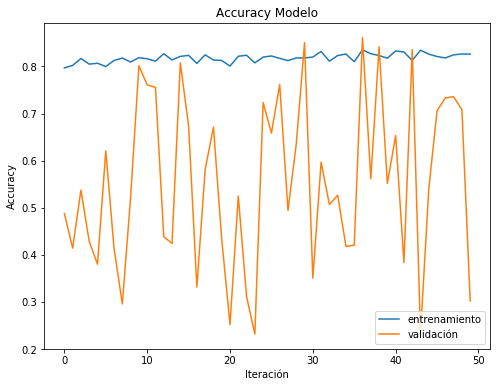

In [364]:
plt.figure(figsize=(8,6))
plt.plot(history_bn_3['acc'])
plt.plot(history_bn_3['val_acc'])
plt.title('Accuracy Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()

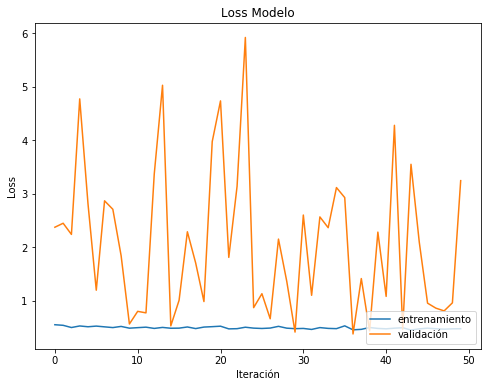

In [363]:
plt.figure(figsize=(8,6))
plt.plot(history_bn_3['loss'])
plt.plot(history_bn_3['val_loss'])
plt.title('Loss Modelo')
plt.ylabel('Loss')
plt.xlabel('Iteración')
plt.legend(['entrenamiento', 'validación'], loc='lower right')
plt.show()

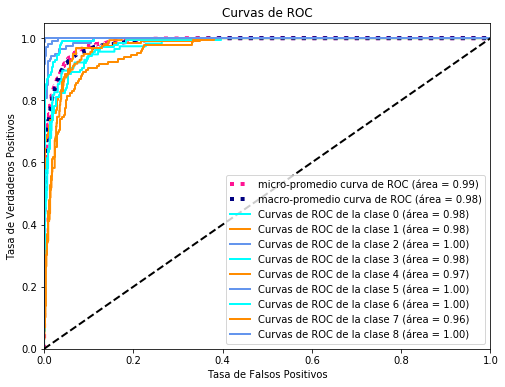

In [344]:
y_pred_prob =  Y_pred
y_pred_classes = y_pred
test_labels_one_hot = to_categorical(test_RN_50_generator_2.classes)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_one_hot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(test_labels_one_hot.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(8,6))
plt.figure(1)
plt.plot((fpr["micro"]), (tpr["micro"]),
         label='micro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)


plt.plot(fpr["macro"], tpr["macro"],
         label='macro-promedio curva de ROC (área = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='Curvas de ROC de la clase {0} (área = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas de ROC')
plt.legend(loc="lower right")
plt.show()

In [345]:
print('Confusion Matrix')
print(confusion_matrix(test_RN_50_generator_2.classes, y_pred))
print('Classification Report')
target_names = ['11', '21','22','23','24','31','32','33','52']
print(classification_report(test_RN_50_generator_2.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 88   0   0   1  21   0   0   5   0]
 [  6  86   6   9   4   0   7   3   0]
 [  0   1 110   8   0   1   0   0   0]
 [  1   6   6 112   1   0   4   7   0]
 [ 11   0   0   1 144   0   0   2   0]
 [  0   0   0   1   0 102   4   0   0]
 [  0   0   0   5   0   4 118   0   1]
 [  0  10   1  15  34   2   4  80   0]
 [  0   0   0   0   0   0   0   0  92]]
Classification Report
              precision    recall  f1-score   support

          11       0.83      0.77      0.80       115
          21       0.83      0.71      0.77       121
          22       0.89      0.92      0.91       120
          23       0.74      0.82      0.78       137
          24       0.71      0.91      0.80       158
          31       0.94      0.95      0.94       107
          32       0.86      0.92      0.89       128
          33       0.82      0.55      0.66       146
          52       0.99      1.00      0.99        92

   micro avg       0.83      0.83      0.83      1124
   macro avg 

In [351]:
def generate_confusion_matrix(cm, classes, normalize=False, title='Matriz de Confusion', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm,2)
        print('Matriz de Confusion Normalizada')
    else:
        print('Matriz de Confusion No Normalizada')
      # print (cm)
    thresh = cm.max()/2
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white'
        if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('Valid data')
    plt.xlabel('Predicted data')

Matriz de Confusion No Normalizada


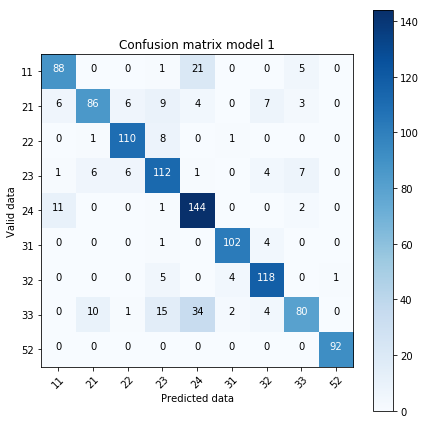

In [352]:
cm = confusion_matrix(test_RN_50_generator_2.classes, y_pred)

cm_plot_labels = ['11', '21','22','23','24','31','32','33','52']
generate_confusion_matrix(cm, cm_plot_labels, title = 'Confusion matrix model 1')

In [349]:
level_1 = {0:0,1:1,2:1,3:1,4:1,5:2,6:2,7:2,8:3}
y_test_lev1 = [level_1[i] for i in test_RN_50_generator_2.classes]  
y_pred_lev1 = [level_1[i] for i in y_pred] 

Matriz de Confusion Normalizada


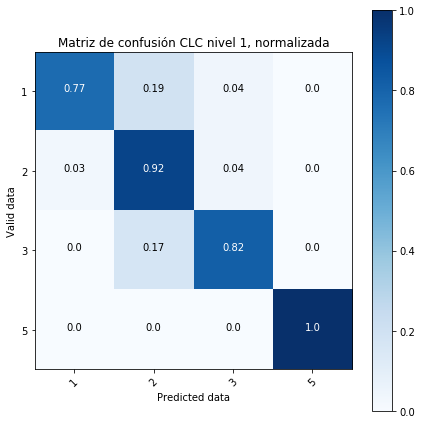

In [353]:
cm_lev1 = confusion_matrix(y_test_lev1, y_pred_lev1)

cm_plot_labels_lev1 = ['1', '2','3','5']
generate_confusion_matrix(cm_lev1, cm_plot_labels_lev1, title = 'Matriz de confusión CLC nivel 1, normalizada',normalize=True)

Matriz de Confusion No Normalizada


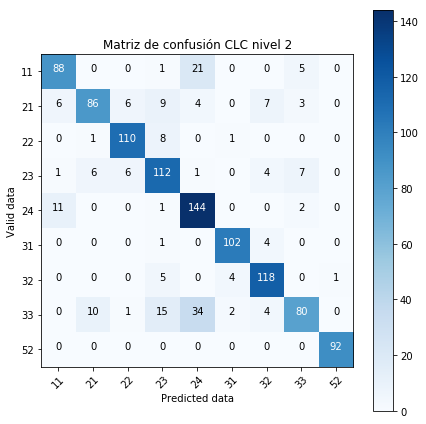

In [354]:
cm = confusion_matrix(test_RN_50_generator_2.classes, y_pred)

cm_plot_labels = ['11', '21','22','23','24','31','32','33','52']
generate_confusion_matrix(cm, cm_plot_labels, title = 'Matriz de confusión CLC nivel 2')

In [355]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(test_RN_50_generator_2.classes, y_pred)
accuracy_lev1 = accuracy_score(y_test_lev1, y_pred_lev1)
print('Accuracy model at level 1 : {} and at level 2 : {}'.format(accuracy_lev1,accuracy))
# precision tp / (tp + fp)
precision = precision_score(test_RN_50_generator_2.classes, y_pred, average = 'macro')
precision_lev1 = precision_score(y_test_lev1, y_pred_lev1, average = 'macro')
print('precision at level 1 : {} and at level 2 : {}'.format(precision_lev1, precision ))
# recall: tp / (tp + fn)
recall = recall_score(test_RN_50_generator_2.classes, y_pred, average = 'macro')
recall_lev1 = recall_score(y_test_lev1, y_pred_lev1, average = 'macro')
print('recall at level 1 : {} and at level 2 : {}'.format( recall_lev1,recall))
# f1: 2 tp / (2 tp + fp + fn)

f1 = f1_score(test_RN_50_generator_2.classes, y_pred, average = 'macro')
f1_lev1 = f1_score(y_test_lev1, y_pred_lev1, average = 'macro')
print('f1 at level 1 : {} and at level 2 : {}'.format(f1_lev1, f1 ))
# kappa
kappa = cohen_kappa_score(test_RN_50_generator_2.classes, y_pred)
kappa_lev1 = cohen_kappa_score(y_test_lev1, y_pred_lev1)
print('kappa at level 1 : {} and at level 2 : {}'.format(kappa_lev1, kappa ))

Accuracy model at level 1 : 0.8790035587188612 and at level 2 : 0.8291814946619217
precision at level 1 : 0.8959212842440196 and at level 2 : 0.8459174224273136
recall at level 1 : 0.8777515409941051 and at level 2 : 0.8382921940421351
f1 at level 1 : 0.8855247325605043 and at level 2 : 0.8364772148941966
kappa at level 1 : 0.8089188057425358 and at level 2 : 0.8071403676529727


In [357]:
import pandas as pd
metricas_df = pd.DataFrame({'Métrica':['Accuracy','Precision','Recall','f1','kappa'],
              'Nivel 1':[accuracy_lev1,precision_lev1,recall_lev1,f1_lev1,kappa_lev1],
              'Nivel 2':[accuracy,precision,recall,f1,kappa]})
metricas_df


Métrica   Nivel 1   Nivel 2
0   Accuracy  0.879004  0.829181
1  Precision  0.895921  0.845917
2     Recall  0.877752  0.838292
3         f1  0.885525  0.836477
4      kappa  0.808919  0.807140